In [0]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os 

%matplotlib inline

In [0]:
os.chdir('drive/My Drive/Dataset')

In [0]:
def Load_Data():
  
  train_set = h5py.File('train_catvnoncat.h5','r')
  train_set_X_orig = np.array(train_set['train_set_x'][:])
  train_set_Y_orig = np.array(train_set['train_set_y'][:])
  
  test_set = h5py.File('test_catvnoncat.h5')
  test_set_X_orig = np.array(test_set['test_set_x'][:])
  test_set_Y_orig = np.array(test_set['test_set_y'][:])
  classes = np.array(test_set['list_classes'][:])
  
  return train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig,classes

In [0]:
def Reshape_And_Normalize(train_set_X_orig,train_set_Y_orig,test_set_X_orig,test_set_Y_orig):
  
  train_set_X = train_set_X_orig.reshape(train_set_X_orig.shape[0],-1).T
  test_set_X = test_set_X_orig.reshape(test_set_X_orig.shape[0],-1).T
  train_set_Y = train_set_Y_orig.reshape(1,train_set_Y_orig.shape[0])
  test_set_Y = test_set_Y_orig.reshape(1,test_set_Y_orig.shape[0])
  
  m_train = train_set_X.shape[1]
  m_test = test_set_X.shape[1]
  
  U_train = np.sum(train_set_X,axis=0,keepdims=True)/train_set_X.shape[0]
  U_test = np.sum(test_set_X,axis=0,keepdims=True)/test_set_X.shape[0]
  train_set_X = train_set_X - U_train
  test_set_X = test_set_X - U_test
  
  sigma_train = np.sqrt(np.sum(np.square(train_set_X),axis=0,keepdims=True)/train_set_X.shape[0])
  sigma_test = np.sqrt(np.sum(np.square(test_set_X),axis=0,keepdims=True)/test_set_X.shape[0])
  
  train_set_X = train_set_X/sigma_train
  test_set_X = test_set_X/sigma_test
  
  assert(sigma_train.shape == (1,m_train) and train_set_Y.shape == (1,m_train))
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y

In [0]:
def Data_Preprocessing():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y,classes = Load_Data()
  #plt.imshow(train_set_X[0])
  print("y = "+str(train_set_Y[0])+". It is a "+classes[train_set_Y[0]].decode('utf-8')+' picture')
  train_set_X,train_set_Y,test_set_X,test_set_Y = Reshape_And_Normalize(train_set_X,train_set_Y,test_set_X,test_set_Y)
  
  return train_set_X,train_set_Y,test_set_X,test_set_Y,classes

In [0]:
def Initialize_Parameters(train_set_X,output_neurons):
  
  parameters={}
  W = np.random.randn(output_neurons,train_set_X.shape[0])*np.sqrt(1/train_set_X.shape[0])
  b = np.zeros((output_neurons,1))
  Y = np.random.randn(output_neurons,1)*np.sqrt(1/train_set_X.shape[0])
  B = np.zeros((output_neurons,1))
  
  parameters['W'] = W 
  parameters['b'] = b
  parameters['Y'] = Y
  parameters['B'] = B
  
  return parameters

In [0]:
def Initialize_Optimizer(parameters):
  
  v = {} 
  s = {}
  dW = np.zeros(parameters['W'].shape)
  db = np.zeros(parameters['b'].shape)
  dY = np.zeros(parameters['Y'].shape)
  dB = np.zeros(parameters['B'].shape)
  
  s['dW'] = v['dW'] = dW
  s['db'] = v['db'] = db
  s['dY'] = v['dY'] = dY
  s['dB'] = v['dB'] = dB
  
  return v,s

In [0]:
def sigmoid(Z):
  
  A = 1/(1+np.exp(-Z))
  return A

In [0]:
def softmax(Z):
  
  exp = np.exp(Z)
  expnorm = np.sum(exp,axis=0,keepdims=True)
  A = exp/expnorm
  assert(expnorm.shape == (1,exp.shape[1]))
  
  return A

In [0]:
def compute_cost_sigmoid(train_set_Y,A,W,regu,lambd):
  
  m_train = train_set_Y.shape[1]
  cost = np.sum(train_set_Y*np.log(A))+np.sum((1-train_set_Y)*np.log(1-A))
  cost = -cost
  if(regu):
    sum = np.sum(np.square(W))*(lambd*0.5/m_train)
    cost = cost + sum
  
  return cost

In [0]:
def compute_cost_softmax(train_set_Y,A,W,regu,lambd):
  
  m_train = train_set_Y.shape[1]
  cost = np.sum(train_set_Y,np.log(A))
  
  if(regu):
    sum = np.sum(np.square(W))*(lambd*0.5/m_train)
    cost = cost + sum
   
  return cost

In [0]:
def Propagation(train_set_X,train_set_Y,parameters,activation,regu,lambd):
  
  m_train = train_set_X.shape[1]
  W = parameters['W']
  b = parameters['b']
  Y = parameters['Y']
  B = parameters['B']
  
  Z = np.dot(W,train_set_X)+b
  mu = np.sum(Z,axis=1,keepdims=True)/m_train
  Z_minus_mu = Z - mu
  sigma = np.sqrt(np.sum(np.square(Z_minus_mu),axis=1,keepdims=True)/m_train)
  ZNorm = Z_minus_mu/sigma
  Zcap = Y * ZNorm + B
  
  if(activation == 'sigmoid'):
    A = sigmoid(Zcap)
    cost = compute_cost_sigmoid(train_set_Y,A,W,regu,lambd)
  elif(activation == 'softmax'):
    A = softmax(Zcap)
    cost = compute_cost_softmax(train_set_Y,A,W,regu,lambd)
    
    
  grads = {}
  dZcap = A-train_set_Y
  dZNorm = Y * dZcap
  dZ = dZNorm/sigma
  dY = np.sum(dZcap * ZNorm,axis=1,keepdims=True)/m_train
  dB = np.sum(dZcap,axis=1,keepdims=True)/m_train
  dW = np.dot(dZ,train_set_X.T)/m_train
  if(regu):
    dW = dW + W*lambd/m_train
  db = np.sum(dZ,axis=1,keepdims=True)/m_train
  
  grads['dW'] = dW
  grads['db'] = db
  grads['dY'] = dY
  grads['dB'] = dB
  
  assert(db.shape == b.shape and dW.shape == W.shape)
  
  return grads,mu,sigma,cost

In [0]:
def Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size):
  
  m_train = train_set_X.shape[1]
  perm = list(np.random.permutation(train_set_X.shape[1]))
  train_set_X = train_set_X[:,perm]
  train_set_Y = train_set_Y[:,perm]
  
  n = int(m_train/mini_batch_size)
  minibatches = []
  
  for i in range(n):
    X = train_set_X[:,i*mini_batch_size:(i+1)*mini_batch_size]
    Y = train_set_Y[:,i*mini_batch_size:(i+1)*mini_batch_size]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  if(m_train % mini_batch_size != 0):
    X = train_set_X[:,n*mini_batch_size:m_train]
    Y = train_set_Y[:,n*mini_batch_size:m_train]
    minibatch = (X,Y)
    minibatches.append(minibatch)
  
  return minibatches

In [0]:
def Update_Parameters(grads,parameters,learning_rate,v,s,beta1,beta2,t,epsilon=1e-8):
  
  t = t+1
  v['dW'] = beta1*v['dW'] + (1-beta1)*grads['dW']
  vdW_corr = v['dW']/(1-(beta1**t))
  v['db'] = beta1*v['db'] + (1-beta1)*grads['db'] 
  vdb_corr = v['db']/(1-(beta1**t))
  v['dY'] = beta1*v['dY'] + (1-beta1)*grads['dY']
  vdY_corr = v['dY']/(1-(beta1**t))
  v['dB'] = beta1*v['dB'] + (1-beta1)*grads['dB']
  vdB_corr = v['dB']/(1-(beta1**t))
  
  s['dW'] = beta2*s['dW'] + (1-beta2)*(grads['dW']**2)
  sdW_corr = s['dW']/(1-(beta2**t))
  s['db'] = beta2*s['db'] + (1-beta2)*(grads['db']**2)
  sdb_corr = s['db']/(1-(beta2**t))
  s['dY'] = beta2*s['dY'] + (1-beta2)*(grads['dY']**2)
  sdY_corr = s['dY']/(1-(beta2**t))
  s['dB'] = beta2*s['dB'] + (1-beta2)*(grads['dB']**2)
  sdB_corr = s['dB']/(1-(beta2**t))
  
  parameters['W'] = parameters['W'] - learning_rate*vdW_corr/(np.sqrt(sdW_corr)+epsilon)
  parameters['b'] = parameters['b'] - learning_rate*vdb_corr/(np.sqrt(sdb_corr)+epsilon)
  parameters['Y'] = parameters['Y'] - learning_rate*vdY_corr/(np.sqrt(sdY_corr)+epsilon)
  parameters['B'] = parameters['B'] - learning_rate*vdB_corr/(np.sqrt(sdB_corr)+epsilon)
  
  return parameters,v,s

In [0]:
def dictionary_to_vector(parameters):
  
  res = np.array([])
  for items in parameters:
    items = parameters[items]
    shape = items.shape
    items = np.reshape(items,shape[0]*shape[1])
    res = np.append(res,items)
    
  return res

In [0]:
def vector_to_dictionary(J,param):
  
  parameters = {}
  j = 0
  for key,value in param.items():
    shape = value.shape
    size = shape[0]*shape[1]
    temp = J[j:j+size]
    j = j+size
    temp = np.reshape(temp,shape)
    parameters[key] = temp
 
  return parameters

In [0]:
def Gradient_Checking_Helper(J,X,Y,param,activation,regu,lambd):
  
  parameters = vector_to_dictionary(J,param)
    
  m_train = X.shape[1]  
  W = parameters['W']
  b = parameters['b'] 
  Y = parameters['Y']
  B = parameters['B']
  
  Z = np.dot(W,X)+b
  mu = np.sum(Z,axis=1,keepdims=True)/m_train
  Z_minus_mu = Z - mu
  sigma = np.sqrt(np.sum(np.square(Z_minus_mu),axis=1,keepdims=True)/m_train)
  ZNorm = Z_minus_mu/sigma
  Zcap = Y * ZNorm + B
  
  if(activation == 'sigmoid'):
    A = sigmoid(Zcap)
    cost = compute_cost_sigmoid(Y,A,W,regu,lambd)
  elif(activation == 'softmax'):
    A = softmax(Zcap)
    cost = compute_cost_softmax(Y,A,W,regu,lambd)
    
  return cost
  

In [0]:
def Gradient_Checking(grads,parameters,X,Y,activation,regu,lambd,epsilon=1e-7):
 
  J = dictionary_to_vector(parameters)
  G_out = dictionary_to_vector(grads)
  m = len(J)
  J_out = np.zeros(m)
  
  for i in range(m):
    J_plus = np.copy(J)
    J_plus[i] = J_plus[i]+epsilon
    cost1 = Gradient_Checking_Helper(J_plus,X,Y,parameters,activation,regu,lambd)
    
    J_minus = np.copy(J)
    J_minus[i] = J_minus[i]-epsilon
    cost2 = Gradient_Checking_Helper(J_minus,X,Y,parameters,activation,regu,lambd)
    
    #print(J,J_plus,J_minus)
    J_out[i] = (cost1-cost2)/(2*epsilon)
 
  dis = np.linalg.norm(J_out-G_out)/(np.linalg.norm(J_out)+np.linalg.norm(G_out))
  
  return dis

In [0]:
def Predict(X,parameters,activation):
  
  W = parameters['W']
  b = parameters['b'] 
  Y = parameters['Y']
  B = parameters['B']
  
  m = X.shape[1]
  Z = np.dot(W,X)+b
  mu = np.sum(Z,axis=1,keepdims=True)/m
  Z_minus_mu = Z - mu
  sigma = np.sqrt(np.sum(np.square(Z_minus_mu),axis=1,keepdims=True)/m)
  ZNorm = Z_minus_mu/sigma
  Zcap = Y*ZNorm + B
  
  if(activation == 'sigmoid'):
    A = sigmoid(Zcap)
    A = np.abs(np.ceil(A-0.5))
    A = A.astype('int32')
  elif(activation == 'softmax'):
    A = softmax(Zcap)
    A = np.argmax(A,axis=0)
    A = np.eye(6)[A]
   
  return A

In [0]:
def Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,output_neurons,mini_batch_size):
  
  beta1 = 0.8
  beta2 = 0.9
  beta3 = 0.99
  lambd = 0.005
  activation = 'sigmoid'
  regu = True
  
  if(activation == 'softmax'):
    train_set_Y = np.eye(6)[train_set_Y]
    test_set_Y = np.eye(6)[test_set_Y]
    
  total_cost = []
  parameters = Initialize_Parameters(train_set_X,output_neurons)
  v,s = Initialize_Optimizer(parameters)
  u = np.zeros((output_neurons,1))
  sig = np.zeros((output_neurons,1))
  
  for i in range(epochs):
    minibatches = Shuffle_And_Split(train_set_X,train_set_Y,mini_batch_size)
    for minibatch in minibatches:
      (X,Y) = minibatch
      grads,mu,sigma,cost = Propagation(X,Y,parameters,activation,regu,lambd)
      u = beta1*u + (1-beta1)*mu
      sig = beta1*sig + (1-beta1)*sigma
      
      if (i % 1000 == 0):
        flag=Gradient_Checking(grads,parameters,X,Y,activation,regu,lambd)
        print("Result of Gradient Checking : "+str(flag))
        
      if(i % 10 == 0):
        total_cost.append(cost)
        
      if(i % 50 == 0):
        print('Cost after '+str(i)+'th Iteration : '+str(cost))
      
      parameters,v,s = Update_Parameters(grads,parameters,learning_rate,v,s,beta2,beta3,i)
  
  A_train = Predict(train_set_X,parameters,activation)
  A_test = Predict(test_set_X,parameters,activation)
  
  if(activation == 'sigmoid'):
    train_acc = 100-np.mean(np.abs(train_set_Y-A_train))*100
    test_acc = 100-np.mean(np.abs(test_set_Y-A_test))*100
    
  elif(activation == 'softmax'):
    train_temp = np.equal(np.argmax(A_train),np.argmax(train_set_Y))
    train_acc = np.mean(train_temp.astype('int32'))
    test_temp = np.equal(np.argmax(A_test),np.argmax(test_set_Y))
    test_acc = np.mean(test_temp.astype('int32'))
  
  print("Training Set Accuracy : "+str(train_acc))
  print("Test Set Accuracy : "+str(test_acc))
  
  plt.plot(total_cost)
  plt.xlabel('Iterations')
  plt.ylabel('Cost')
  plt.title("Learning_Rate : "+str(learning_rate))
  plt.show()  
  
  return parameters

In [0]:
def Caller_Function():
  
  train_set_X,train_set_Y,test_set_X,test_set_Y,classes = Data_Preprocessing()
  learning_rate = 0.001
  epochs = 1000
  mini_batch_size = 32
  output_neurons = 1
  parameters = Model(train_set_X,train_set_Y,test_set_X,test_set_Y,learning_rate,epochs,output_neurons,mini_batch_size)
  
  for key,value in parameters.items():
    print(key,value)

y = 0. It is a non-cat picture
Result of Gradient Checking : 0.9743991555778564
Cost after 0th Iteration : 22.165281888079978
Result of Gradient Checking : 0.970625442603922
Cost after 0th Iteration : 22.108473045856986
Result of Gradient Checking : 0.968139287622383
Cost after 0th Iteration : 22.201733265887405
Result of Gradient Checking : 0.9803892688543225
Cost after 0th Iteration : 22.111349455189544
Result of Gradient Checking : 0.9842144621692328
Cost after 0th Iteration : 22.1375240116449
Result of Gradient Checking : 0.9884653340104572
Cost after 0th Iteration : 22.171265645445335
Result of Gradient Checking : 0.9786024211478094
Cost after 0th Iteration : 11.759615317487416
Cost after 50th Iteration : 20.219168636803794
Cost after 50th Iteration : 20.628961875356385
Cost after 50th Iteration : 21.153496334660854
Cost after 50th Iteration : 20.680459583380948
Cost after 50th Iteration : 19.608900469206528
Cost after 50th Iteration : 20.063016636163
Cost after 50th Iteration : 1

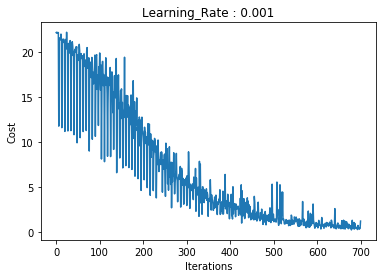

W [[-0.2282553   0.26556649  0.09247469 ... -0.04821143  0.24209406
  -0.48798425]]
b [[2.00964715]]
Y [[-5.64782583]]
B [[-1.85033131]]


In [113]:
Caller_Function()